# SpikeInterface v0.98.2 - Adapted by Rodrigo Noseda - July 2023

SpikeInterface to analyze a 128-channel dataset from from Cambridge Neurotech Probes. 
The dataset is extracted using open-ephys DAQ and Bonsai-rx (in .bin).
Event_timestamps need some work.

# 0. Preparation <a class="anchor" id="preparation"></a>

In [2]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from pathlib import Path
import spikeinterface_gui as sigui
import warnings
warnings.simplefilter("ignore")
%matplotlib widget
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.98.2


# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [3]:
# file paths
base_folder = Path('.')
data_folder = Path("C:/Users/rodri/Documents/Bonsai-RN/Bonsai_DataRN/2023_3_21/")
#Pasted directly from explorer "C:\Users\rodri\Documents\Bonsai-RN\Bonsai_DataRN\2023_3_21\"
recording_file = data_folder / "RawEphysData_64Ch_F-Probe10.bin"
start_time_file = data_folder / "StartRecording_Time_0.csv"
events_file = data_folder / "Events_0.csv"
events10s_file = data_folder / "Events_10s_Tone_0.csv"
events20s_file = data_folder / "Events_20s_Tone_0.csv"
# parameters to load the bin/dat format
num_channels = 64 #must know apriori; modify in probe below accordingly.
sampling_frequency = 30000
gain_to_uV = 0.195
offset_to_uV = 0
t_starts = 0
dtype = "float32"
time_axis = 0

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 30000
Number of channels: 64
Number of segments: 1
Trace Shape: (5400000, 64)
Trace Total Duration: 14356.04
Trace Total Samples: 430681200


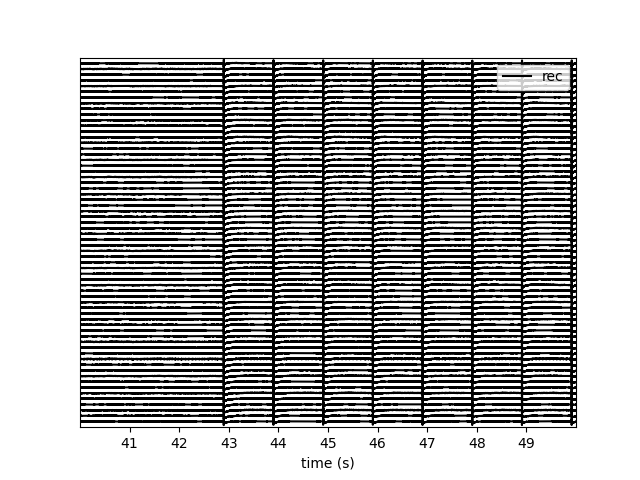

In [4]:
recording = si.read_binary(recording_file, num_chan=num_channels,sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis, is_filtered=False)

channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*180))
trace_total_duration = recording.get_total_duration()
trace_total_samples = recording.get_total_samples()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")
print('Trace Shape:', trace_snippet.shape)
print('Trace Total Duration:', trace_total_duration)
print('Trace Total Samples:', trace_total_samples)
recording_1min_slice = recording.frame_slice(start_frame=int(0), end_frame=int(fs*120)) 
sw.plot_timeseries(recording_1min_slice, time_range=(40, 50)) #in samples=30000samples*60sec (fs*60)

list_triggers = [42, 43]
recording_clean = spre.remove_artifacts(recording, list_triggers, ms_before=100, ms_after=1000, mode='zeros', 
                                              fit_sample_spacing=1.0, list_labels=None, artifacts=None, sparsity=None, 
                                              scale_amplitude=False, time_jitter=0, 
                                              waveforms_kwargs={'allow_unfiltered': True, 'mode': 'memory'})
start_frame = 42
end_frame = 45
list_periods = (start_frame, end_frame)
rec_cut = spre.silence_periods(recording, list_periods, mode='zeros')

sw.plot_timeseries(recording, time_range=(40, 50)) #in samples=30000samples*60sec (fs*60)
sw.plot_timeseries(recording_clean, time_range=(40, 50))
sw.plot_timeseries(rec_cut, time_range=(40, 50))

In [5]:
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface import generate_linear_probe, get_probe, generate_multi_shank
from probeinterface import combine_probes
from probeinterface import generate_multi_columns_probe
from probeinterface.plotting import plot_probe, plot_probe_group 
from probeinterface import generate_dummy_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
print(f"ProbeInterface version: {pi.__version__}")

ProbeInterface version: 0.2.17


Run code below get the probe from library.

cambridgeneurotech - ASSY-158-F - 64ch - 6shanks
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64']
['4' '5' '4' '4' '4' '5' '5' '5' '5' '4' '4' '5' '5' '5' '5' '5' '4' '3'
 '4' '3' '4' '3' '3' '4' '3' '3' '3' '3' '3' '3' '4' '3' '2' '1' '2' '2'
 '2' '2' '2' '2' '1' '2' '2' '1' '2' '1' '2' '1' '0' '0' '0' '1' '0' '1'
 '1' '0' '1' '1' '0' '1' '0' '0' '0' '0']


(<matplotlib.collections.PolyCollection at 0x285804564f0>,
 <matplotlib.collections.PolyCollection at 0x285803ff9d0>)

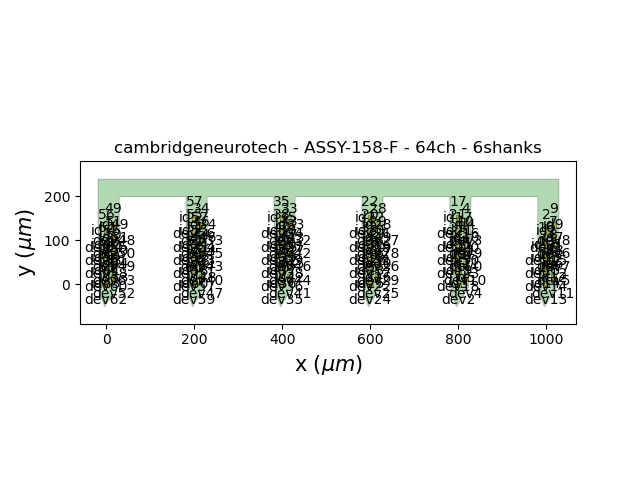

In [6]:
probeF64 = pi.get_probe(manufacturer='cambridgeneurotech',
                     probe_name= 'ASSY-158-F')#probe object from library comes with contact and shank info.
device_channel_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
               21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
               41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63] #Modify accordingly.
probeF64.set_device_channel_indices(device_channel_indices)
print(probeF64)
print(probeF64.device_channel_indices)
print(probeF64.contact_ids)
print(probeF64.shank_ids)

plot_probe(probeF64, with_channel_index=True, with_device_index=True, with_contact_id=True)

In [ ]:
#device_channel_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
#               21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
#               41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,
#               61,62,63] #based on how recording was saved in Bonsai (mapped channels saved).

The probe now has contact ids `id#` and device ids `dev#`! Note that also the `shank_id` is loaded with the probe. We can also visualize the probe information as a `pandas` dataframe:


In [7]:
probeF64.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,4,0
1,2,5,1
2,3,4,2
3,4,4,3
4,5,4,4
...,...,...,...
59,60,1,59
60,61,0,60
61,62,0,61
62,63,0,62


A probe (prb) or `probeinterface` object can be loaded directly to a SI recording object:
-In the case below, a group is formed from each shank - 'by_shank'

In [9]:
recording_prb = recording.set_probe(probeF64, group_mode="by_shank")


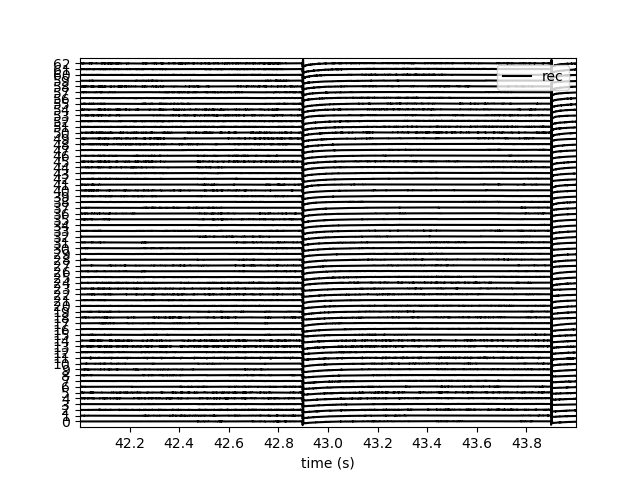

In [10]:
A = recording_prb.get_channel_ids()
recording_slice = recording_prb.channel_slice(A[0:63])
#recording_1min_slice = recording.frame_slice(start_frame=int(0), end_frame=int(fs*60))
w_ts = sw.plot_timeseries(recording_slice, channel_ids=None, order_channel_by_depth=False,
                          time_range=(42, 44), show_channel_ids= True, backend="matplotlib", clim=None)

After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

# 2. Preprocessing <a class="anchor" id="preprocessing"></a>

All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data. We will focus only on the first shank (group `0`) for now.

In [ ]:
import csv
# Function to convert time format
def convert_time_format(time_str):
    hh, mm, ss_sssssss = time_str.split(':')
    ss, sssssss = ss_sssssss.split('.')
    sss = sssssss[:3]
    return f"{hh}:{mm}:{ss}.{sss}"

# Read the start timestamp from the file above
with open(start_time_file, 'r') as file:
    reader = csv.reader(file)
    start_timestamp = next(reader)[0]
    start_timestamp = convert_time_format(start_timestamp)
   
# Read the event timestamp from the file above
with open(events_file, 'r') as file:
    reader = csv.reader(file)
    events_timestamp = next(reader)[0]
    events_timestamp = convert_time_format(events_timestamp)
    
# Read the event10s timestamp from the file above
with open(events10s_file, 'r') as file:
    reader = csv.reader(file)
    events10s_timestamp = next(reader)[0]
    events10s_timestamp = convert_time_format(events10s_timestamp)    
    
# Read the event20s timestamp from the file above
with open(events20s, 'r') as file:
    reader = csv.reader(file)
    events20s_timestamp = next(reader)[0]
    events20s_timestamp = convert_time_format(events20s_timestamp) 

print(start_timestamp)
print(events)
print(events10s)
print(events20s)

In [ ]:
list_triggers = (42.8, 43.8)
rec_clean = si.remove_artifacts(recording_prb, list_triggers)

In [ ]:
triggers =[50]
recording_removeart = spre.remove_artifacts(recording_prb, list_triggers=triggers, ms_before=1, ms_after=10000, 
                      mode='linear', fit_sample_spacing=1.0, list_labels=None, artifacts=None, 
                      sparsity=None, scale_amplitude=False, time_jitter=0, 
                      waveforms_kwargs={'allow_unfiltered': True, 'mode': 'memory'})

#recording_removeart = spre.RemoveArtifactsRecording(recording_prb, list_triggers=triggers, ms_before=0.5, ms_after=3)
print(recording_removeart)


In [ ]:
#C = recording_removeart.get_channel_ids()
recording_slice = recording_removeart.channel_slice(A[0:7])
w_ts = sw.plot_timeseries(recording_slice, channel_ids=None, order_channel_by_depth=False,
                          time_range=(40, 60), show_channel_ids= True, backend="matplotlib", clim=None)

In [ ]:
recordings_by_group = recording_prb.split_by("group")
recording_to_process = recordings_by_group[0]
recording_to_process.get_num_channels()
recording_f = spre.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')


#recording_removeart = spre.RemoveArtifactsRecording(recording_prb, list_triggers=triggers, ms_before=0.5, ms_after=3)
print(recording_to_process)
print(recording_cmr)

## Take only 1 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [ ]:
#fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=180*fs)
print(recording_sub)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [ ]:
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)
global_job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)
#set_global_job_kwargs(**global_job_kwargs)
#print(get_global_job_kwargs())

In [ ]:
if (base_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(base_folder / "preprocessed")
else:
    recording_saved = recording_cmr.save(folder=base_folder / "preprocessed", **job_kwargs)
    
print(recording_saved)
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. The `save` returns a new *cached* recording that has all the previously loaded information: 

After saving the SI object, we can easily load it back in a new session:

In [ ]:
recording_loaded = si.load_extractor(base_folder/"preprocessed")
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

We can double check that the traces are exactly the same as the `recording_saved` that we saved:

In [ ]:
fig, axs = plt.subplots(ncols=2)
w_saved = sw.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = sw.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 5. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in `SpikeInterface` to see if `tridesclous` is available. Then we can then check the `tridesclous` default parameters.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [ ]:
ss.installed_sorters()

In [ ]:
from pprint import pprint
default_SC2_params = ss.get_default_sorter_params('spykingcircus2')
# Parameters can be changed by single arguments: 
#default_TDC_params['detect_threshold'] = 3 
#default_TDC_params['freq_max'] = 6000
#default_TDC_params['freq_min'] = 300
pprint(default_SC2_params)

In [ ]:
# run spike sorting on entire recording
sorting_SC2 = ss.run_sorter('spykingcircus2', recording_loaded, 
                            output_folder=base_folder / 'results_SC2_7-21-23', 
                            n_jobs=-1, chunk_size=30000, verbose=True)

In [ ]:
sorting_SC2

SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

We can use `spikewidgets` functions for some quick visualizations:

In [ ]:
w_rs = sw.plot_rasters(sorting_SC2)

# 6. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core module uses `WaveformExtractor` fro extracting waveforms from paired recording-sorting objects. It retrieves waveforms and templates.

In [ ]:
si.extract_waveforms?

In [ ]:
we_all = si.extract_waveforms(recording_loaded, sorting_SC2, folder=base_folder / "wf_SC2b_all", 
                              max_spikes_per_unit=None, load_if_exists=True, **job_kwargs)

In [ ]:
for unit in sorting_SC2.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting_SC2.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `postprocessing` module.

# 7. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [ ]:
we_all.get_available_extension_names()

In [ ]:
pc = spost.compute_principal_components(we_all, n_components=3, load_if_exists=True)
amplitudes = spost.compute_spike_amplitudes(we_all, outputs="by_unit", load_if_exists=True, 
                                            **job_kwargs)
unit_locations = spost.compute_unit_locations(we_all, method="monopolar_triangulation", load_if_exists=True)
spike_locations = spost.compute_spike_locations(we_all, method="monopolar_triangulation", load_if_exists=True,
                                                **job_kwargs)
ccgs, bins = spost.compute_correlograms(we_all)
template_metrics = spost.calculate_template_metrics(we_all)
sparsity_radius = spost.get_template_channel_sparsity(we_all, method="radius", radius_um=50)
similarity = spost.compute_template_similarity(we_all)

qm = sqm.compute_quality_metrics(we_all)

In [ ]:
from ipywidgets import widgets
sw.plot_unit_locations(we_all, backend="ipywidgets")
sw.plot_spike_locations(we_all, backend="ipywidgets")
sw.plot_amplitudes(we_all, backend="ipywidgets")
sw.plot_autocorrelograms(we_all, unit_ids=sorting_SC2.unit_ids[:4])
sw.plot_crosscorrelograms(we_all, unit_ids=sorting_SC2.unit_ids[:4])
sw.plot_unit_templates(we_all, backend="matplotlib")

In [ ]:
isi_viol_thresh = 0.2
amp_cutoff_thresh = 0.8

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [ ]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

and then we can use the query to select units:

In [ ]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values

In [ ]:
sorting_auto = sorting_SC2.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting_SC2.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

# 9. Viewers <a class="anchor" id="viewers"></a>

Let's check put the `spikeinterface-gui` to explore our spike sorting results:

### SpikeInterface GUI

In [ ]:
!sigui waveforms/

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html): 

# 11. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [ ]:
sexp.export_to_phy(we_all, output_folder=base_folder / 'phy_SC2b', 
                   **job_kwargs)

In [ ]:
%%capture --no-display
!phy template-gui phy_SC2b/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
sorting_phy_curated = se.PhySortingExtractor(base_folder / 'phy_SC2/', exclude_cluster_groups=['noise'])

In [ ]:
print(f"Number of units before curation: {len(sorting_SC2.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")

In [ ]:
import numpy as np 
b = np.load(base_folder / 'phy_SC2b/spike_clusters.npy')
print(b)
print(len(b))